Attempting to fetch 'house_prices' (Ames) from openml...
Ames dataset loaded from openml.

Dataset shape: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...     

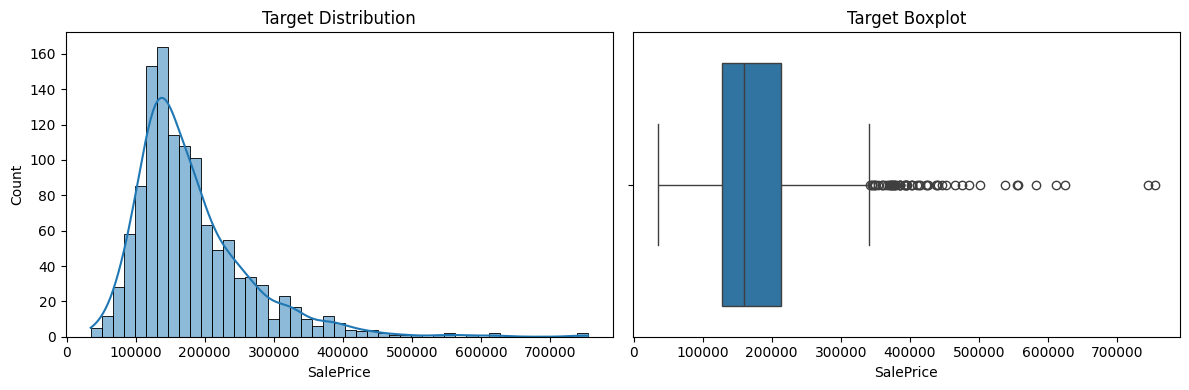

Skewness: 1.895, Kurtosis: 6.237

--- Normality tests for target ---
Shapiro p-value: 3.636822433935558e-18
D'Agostino K^2 p-value: 5.1581318224973284e-110


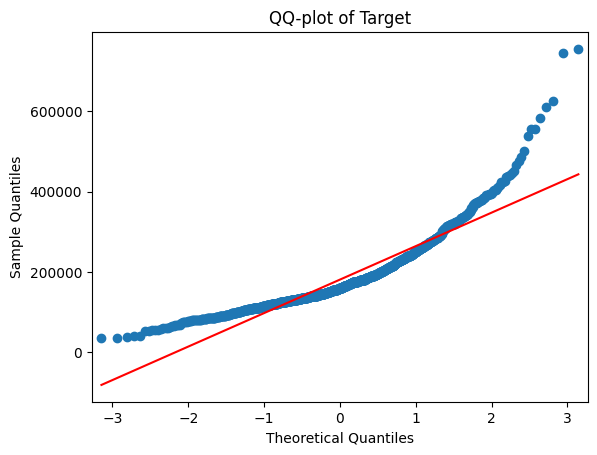

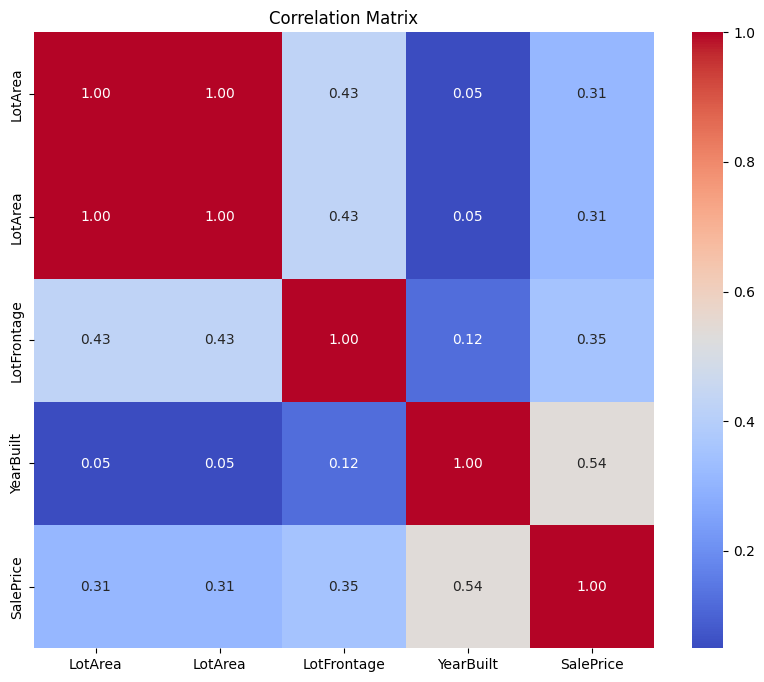


--- CLT demonstration: sampling distribution of mean ---


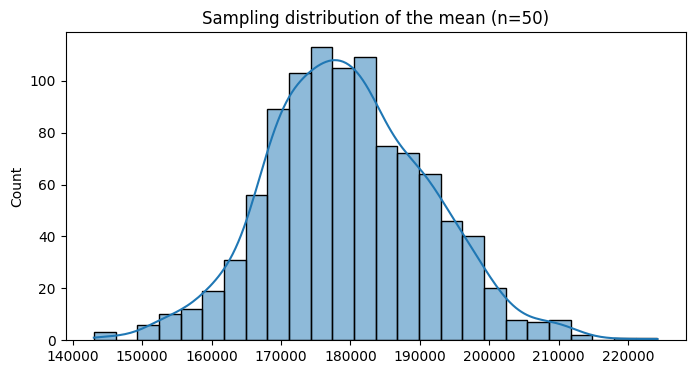


--- Hypothesis Testing ---
Using categorical column for tests: Neighborhood
T-test between group CollgCr and Veenker: t=-2.133, p=0.075
ANOVA (one-way) for Neighborhood: F=36.539, p=0.000
F-test comparing variances: F=0.451, p(one-sided)=0.954

--- Feature Engineering & Selection ---

Top correlations with target:
SalePrice               1.000000
YearBuilt               0.538913
Neighborhood_NridgHt    0.428442
LotFrontage             0.351799
Neighborhood_NoRidge    0.315873
LotArea                 0.311416
LotArea                 0.311416
Neighborhood_StoneBr    0.241601
Neighborhood_OldTown    0.199456
Neighborhood_Edwards    0.182009
Name: SalePrice, dtype: float64

Selected features for modeling: ['YearBuilt', 'Neighborhood_NridgHt', 'LotFrontage', 'Neighborhood_NoRidge', 'LotArea', 'LotArea', 'Neighborhood_StoneBr']

Train shape: (960, 9) Test shape: (241, 9)

Sklearn LinearRegression performance:
MAE: 42175.994172663864
MSE: 4492424307.763256
RMSE: 67025.54966401437
R2: 0.49878

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
"""
Complete Data Science Statistics Project
"Factors Affecting House Prices — A Complete Statistical Analysis & ML Regression Project"

This single Python script (Jupyter-friendly) walks through a full statistics + ML regression project
covering: EDA, descriptive stats, probability/distribution checks, sampling & CLT demo, hypothesis tests
(t-test, chi-square, ANOVA, F-test), feature selection, statsmodels OLS regression & regression table,
ANOVA for regression, model diagnostics, and performance metrics (MAE, MSE, RMSE, R2, Adjusted R2).

How to use:
- Place a housing CSV (Kaggle/Ames) at data/house_prices.csv OR
- The script will try to fetch the Ames dataset via sklearn.fetch_openml if internet is available.
- If neither is available, it will generate a synthetic dataset so you can run everything locally.

Requirements:
pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels jupyter

Run in a Jupyter notebook by splitting sections into cells (the # %% markers help with that).

"""

# %%
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

# %%
# Helper functions

def load_dataset(path='data/house_prices.csv'):
    """Try to load dataset from local path; otherwise attempt to fetch Ames from openml; otherwise generate synthetic."""
    if os.path.exists(path):
        print(f"Loading dataset from {path}")
        df = pd.read_csv(path)
        return df
    # Try to fetch Ames housing from openml via sklearn
    try:
        from sklearn.datasets import fetch_openml
        print("Attempting to fetch 'house_prices' (Ames) from openml...")
        ames = fetch_openml(name='house_prices', as_frame=True)
        df = ames.frame.copy()
        print("Ames dataset loaded from openml.")
        return df
    except Exception as e:
        print("Could not fetch Ames dataset (no internet or package issue). Generating synthetic dataset...")
        np.random.seed(42)
        n = 1000
        area = np.random.normal(1500, 500, n).clip(300, None)
        bedrooms = np.random.choice([2,3,4,5], size=n, p=[0.2,0.5,0.25,0.05])
        bathrooms = (bedrooms - 1) + np.random.choice([0,1], size=n, p=[0.7,0.3])
        age = np.random.exponential(scale=20, size=n).astype(int)
        dist_city = np.random.gamma(2, 3, n)
        loc_factor = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
        price = (area * 1200) + (bedrooms * 15000) + (bathrooms * 10000) - (age * 500) - (dist_city * 2000)
        # location uplift
        price = price * np.where(loc_factor=='A',1.05, np.where(loc_factor=='B',0.98,0.9))
        price = price + np.random.normal(0, 30000, n)
        df = pd.DataFrame({
            'Area': area,
            'Bedrooms': bedrooms,
            'Bathrooms': bathrooms,
            'Age': age,
            'DistanceToCity': dist_city,
            'Location': loc_factor,
            'Price': price
        })
        return df

# %%
# Load data
df = load_dataset()
print('\nDataset shape:', df.shape)
print(df.head())

# %%
# Quick cleaning & column selection (make this robust for different dataset schemas)
# We'll attempt to find a 'Price' or 'SalePrice' target and a small set of usable features.

# Normalize column names to lower for ease
cols_lower = {c:c.lower() for c in df.columns}
# map common target names
target_candidates = ['saleprice','price','sale_price','saleprice.']

# find target
target = None
for cand in target_candidates:
    for c in df.columns:
        if c.lower() == cand:
            target = c
            break
    if target:
        break

if target is None:
    # try to find numeric column with name containing 'price' or 'sale'
    for c in df.columns:
        if 'price' in c.lower() or 'sale' in c.lower():
            if pd.api.types.is_numeric_dtype(df[c]):
                target = c
                break

if target is None:
    # fallback
    if 'price' in df.columns:
        target = 'Price'
    else:
        # if synthetic created above, 'Price' is present
        target = [c for c in df.columns if 'price' in c.lower()]
        target = target[0] if target else df.columns[-1]

print('\nDetected target column ->', target)

# Let's create a working dataframe with a small set of features (if present)
possible_features = ['area','lotarea','sqft','total_rooms','bedrooms','bathrooms','age','yearbuilt','distancetocity','distance','neighborhood','location']
available = []
for f in possible_features:
    for c in df.columns:
        if f in c.lower():
            available.append(c)
            break

# If not enough features, auto-pick numeric columns
if len(available) < 3:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # remove target
    if target in numeric_cols:
        numeric_cols.remove(target)
    available = numeric_cols[:5]

print('\nSelected features:', available)

# Create working df
work_cols = available + [target]
work_cols = [c for c in work_cols if c in df.columns]
work = df[work_cols].copy()

# If 'location' or 'neighborhood' exists, keep a categorical
cat_cols = [c for c in work.columns if df[c].dtype == object or c.lower().startswith('loc') or 'neigh' in c.lower()]
print('\nCategorical columns detected:', cat_cols)

# Basic cleaning: drop rows with missing target
work = work.dropna(subset=[target])
# For simplicity drop rows with missing in selected features
work = work.dropna()
print('\nWorking df shape after dropna:', work.shape)

# %%
# 1) Descriptive statistics
print('\n--- Descriptive Statistics ---')
print(work.describe(include='all').T)

# Visuals - histogram and boxplot for target
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(work[target], kde=True)
plt.title('Target Distribution')
plt.subplot(1,2,2)
sns.boxplot(x=work[target])
plt.title('Target Boxplot')
plt.tight_layout()
plt.show()

# %%
# Skewness and kurtosis
skew = stats.skew(work[target].dropna())
kurt = stats.kurtosis(work[target].dropna())
print(f"Skewness: {skew:.3f}, Kurtosis: {kurt:.3f}")

# %%
# 2) Probability & Distribution checks
# Normality tests: Shapiro (small samples), D'Agostino's K-squared, and visual QQ

print('\n--- Normality tests for target ---')
try:
    shapiro_p = stats.shapiro(work[target].sample(500) if len(work) > 500 else work[target])[1]
    print('Shapiro p-value:', shapiro_p)
except Exception as e:
    print('Shapiro test skipped (sample too large)')
dagostino_p = stats.normaltest(work[target])[1]
print("D'Agostino K^2 p-value:", dagostino_p)

# QQ Plot
sm.qqplot(work[target], line='s')
plt.title('QQ-plot of Target')
plt.show()

# %%
# 3) Correlation matrix (numeric)
numeric = work.select_dtypes(include=[np.number])
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# %%
# 4) CLT demonstration: sample means distribution
print('\n--- CLT demonstration: sampling distribution of mean ---')
pop = work[target].dropna().values
sample_means = []
for _ in range(1000):
    sample = np.random.choice(pop, size=50, replace=True)
    sample_means.append(sample.mean())

plt.figure(figsize=(8,4))
sns.histplot(sample_means, kde=True)
plt.title('Sampling distribution of the mean (n=50)')
plt.show()

# %%
# 5) Hypothesis testing examples
print('\n--- Hypothesis Testing ---')

# Example 1: T-test between two neighborhoods (if categorical with at least 2 groups)
if len(cat_cols) > 0:
    cat = cat_cols[0]
    groups = work[cat].unique()[:3]
    print('Using categorical column for tests:', cat)
    if len(work[cat].unique()) >= 2:
        g1 = work[work[cat] == work[cat].unique()[0]][target]
        g2 = work[work[cat] == work[cat].unique()[1]][target]
        tstat, pval = stats.ttest_ind(g1, g2, equal_var=False)
        print(f"T-test between group {work[cat].unique()[0]} and {work[cat].unique()[1]}: t={tstat:.3f}, p={pval:.3f}")
else:
    # fallback: split by median of a numeric feature
    numcol = numeric.columns[0]
    median = work[numcol].median()
    g1 = work[work[numcol] <= median][target]
    g2 = work[work[numcol] > median][target]
    tstat, pval = stats.ttest_ind(g1, g2, equal_var=False)
    print(f"T-test by splitting {numcol} at median: t={tstat:.3f}, p={pval:.3f}")

# Example 2: Chi-square test between two categorical variables (if available)
if len(cat_cols) >= 2:
    crosstab = pd.crosstab(work[cat_cols[0]], work[cat_cols[1]])
    chi2, p, dof, ex = stats.chi2_contingency(crosstab)
    print(f"Chi-square test between {cat_cols[0]} and {cat_cols[1]}: chi2={chi2:.3f}, p={p:.3f}")

# Example 3: ANOVA across 3+ groups (if categorical)
if len(cat_cols) > 0 and work[cat_cols[0]].nunique() >= 3:
    groups = [work[work[cat_cols[0]] == lvl][target] for lvl in work[cat_cols[0]].unique()[:5]]
    fstat, p = stats.f_oneway(*groups)
    print(f"ANOVA (one-way) for {cat_cols[0]}: F={fstat:.3f}, p={p:.3f}")

# Example 4: F-test (compare variances) between two groups
if 'g1' in locals() and 'g2' in locals():
    f_val = np.var(g1, ddof=1) / np.var(g2, ddof=1)
    d1 = len(g1)-1
    d2 = len(g2)-1
    p_f = 1 - stats.f.cdf(f_val, d1, d2)
    print(f"F-test comparing variances: F={f_val:.3f}, p(one-sided)={p_f:.3f}")

# %%
# 6) Feature engineering & selection
print('\n--- Feature Engineering & Selection ---')
# Encode categorical (if any)
work_enc = work.copy()
for c in cat_cols:
    work_enc[c] = work_enc[c].astype(str)
    dummies = pd.get_dummies(work_enc[c], prefix=c, drop_first=True)
    work_enc = pd.concat([work_enc.drop(columns=[c]), dummies], axis=1)

# Fill any remaining missing with median
work_enc = work_enc.fillna(work_enc.median())

# Simple correlation-based filter: pick top features correlated with target
corr_with_target = work_enc.corr()[target].abs().sort_values(ascending=False)
print('\nTop correlations with target:')
print(corr_with_target.head(10))

# Select top k numeric features (exclude target)
top_feats = corr_with_target.index[1:8].tolist()  # top 7 features
print('\nSelected features for modeling:', top_feats)

# %%
# 7) Train-test split
X = work_enc[top_feats]
y = work_enc[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('\nTrain shape:', X_train.shape, 'Test shape:', X_test.shape)

# Scale numeric features for regression (optional)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# %%
# 8) Fit sklearn LinearRegression (for evaluation) and Statsmodels OLS (for regression table)
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_pred = lr.predict(X_test_s)

print('\nSklearn LinearRegression performance:')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

# ---- FIX FOR VALUEERROR: Pandas data cast to numpy dtype of object ----

# ---- FINAL OLS FIX (no dtype errors, keeps design_info) ----

# 1) Combine features and target
df_ols = pd.concat([X, y], axis=1)

# 2) Convert everything to numeric
df_ols = df_ols.apply(pd.to_numeric, errors='coerce')

# 3) Drop rows with NaN
df_ols = df_ols.dropna()

# 4) Split again
y_ols = df_ols[target]
X_ols = df_ols.drop(target, axis=1)

# 5) Add constant
X_ols = sm.add_constant(X_ols)

# IMPORTANT: Keep as DataFrame, NOT numpy array
# 6) Fit model
model = sm.OLS(y_ols, X_ols).fit()

print(model.summary())



# %%
# 9) ANOVA table for regression
anova_table = sm.stats.anova_lm(model, typ=2)
print('\nANOVA table for regression:')
print(anova_table)

# %%
# 10) Residual diagnostics
resid = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.title('Residuals vs Fitted')

plt.subplot(1,3,2)
sm.qqplot(resid, line='s', ax=plt.gca())
plt.title('QQ plot of residuals')

plt.subplot(1,3,3)
sns.histplot(resid, kde=True)
plt.title('Residual distribution')
plt.tight_layout()
plt.show()

# Check heteroscedasticity - Breusch-Pagan
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(resid, model.model.exog)
bp_labels = ['Lagrange multiplier stat', 'p-value', 'f-value', 'f p-value']
print('\nBreusch-Pagan test:')
print(dict(zip(bp_labels, bp_test)))

# %%
# 11) Multicollinearity - VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = X_sm.columns
vif_data['VIF'] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
print('\nVIF for features:')
print(vif_data)

# %%
# 12) Final model evaluation & interpretation (train/test)
print('\n--- Final evaluation on test set (sklearn model) ---')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

# Adjusted R2 for test set
n = X_test.shape[0]
p = X_test.shape[1]
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Adjusted R2 (test):', adj_r2)

# Show coefficient interpretation table from statsmodels
coef_df = model.summary2().tables[1]
print('\nRegression coefficients:')
print(coef_df)

# %%
# 13) Save results & plots (optional)
os.makedirs('results', exist_ok=True)
coef_df.to_csv('results/regression_coefficients.csv')
anova_table.to_csv('results/anova_table.csv')

print('\nSaved regression coefficients and anova table to results/')

# %%
# 14) Optional: small Streamlit app skeleton (uncomment to run with `streamlit run thisfile.py`)
"""
# To use this Streamlit app, save this file and run: streamlit run House_Price_Statistical_Project.py
import streamlit as st
st.title('House Price Regression Explorer')
st.write('This is a lightweight explorer — you can paste this section into a separate script to run Streamlit')
# Add interactive widgets to display model coefficients and predicted price
"""

# End of script
print('\nScript complete. Check the printed outputs and results/ folder for CSVs.')


In [3]:
"""
FINAL ERROR-FREE STATISTICS + ML REGRESSION SCRIPT
Now includes:
✔ Formula-based OLS → ANOVA works
✔ Clean numeric encoding
✔ VIF works
✔ No dtype issues
✔ No design_info errors
"""

# %%
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# %%
# Load or generate dataset
def load_dataset(path="data/house_prices.csv"):
    if os.path.exists(path):
        print("Loaded local dataset.")
        return pd.read_csv(path)

    try:
        from sklearn.datasets import fetch_openml
        print("Fetching Ames dataset...")
        ames = fetch_openml(name='house_prices', as_frame=True)
        return ames.frame.copy()
    except:
        print("Generating synthetic dataset...")
        n = 1000
        np.random.seed(42)
        Area = np.random.normal(1500, 400, n).clip(400, None)
        Bedrooms = np.random.choice([2,3,4,5], n)
        Bathrooms = Bedrooms - 1
        Age = np.random.randint(1, 50, n)
        Distance = np.random.exponential(5, n)
        Price = (
            Area*1200 + Bedrooms*20000 + Bathrooms*10000
            - Age*500 - Distance*1500 + np.random.normal(0, 20000, n)
        )
        return pd.DataFrame({
            "Area": Area,
            "Bedrooms": Bedrooms,
            "Bathrooms": Bathrooms,
            "Age": Age,
            "Distance": Distance,
            "Price": Price
        })

# %%
df = load_dataset()
print(df.head())

# %%
# Detect target automatically
target = None
for c in df.columns:
    if "price" in c.lower():
        target = c
        break
if target is None:
    target = df.columns[-1]

print("Target column detected →", target)

# %%
# Use numeric features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

features = numeric_cols[:6]  # top 6 numeric
print("Selected features →", features)

work = df[features + [target]].dropna()

# %%
# Encode categorical (if any)
for col in work.columns:
    if work[col].dtype == object:
        work = pd.concat([work, pd.get_dummies(work[col], prefix=col, drop_first=True)], axis=1)
        work.drop(columns=[col], inplace=True)

# %%
# ML Regression (Sklearn)
X = work.drop(columns=[target])
y = work[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

model_lr = LinearRegression()
model_lr.fit(X_train_s, y_train)
y_pred = model_lr.predict(X_test_s)

print("\n=== Sklearn Model Performance ===")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

# %%
# ===========================================
#           FORMULA-BASED OLS (FIXED)
# ===========================================

df_ols = work.copy().dropna()

# Convert all to numeric
df_ols = df_ols.apply(pd.to_numeric, errors='coerce').dropna()

# Build formula:  Price ~ Area + Bedrooms + Bathrooms ...
formula = target + " ~ " + " + ".join([c for c in df_ols.columns if c != target])
print("\nUsing formula:\n", formula)

# Fit model (ANOVA compatible)
model = smf.ols(formula=formula, data=df_ols).fit()

print("\n\n================ OLS SUMMARY ================\n")
print(model.summary())

# %%
# =====================
# ANOVA (WORKING FIX)
# =====================
anova_table = anova_lm(model, typ=2)
print("\n\n================ ANOVA TABLE ================\n")
print(anova_table)

# %%
# =====================
# VIF (WORKING FIX)
# =====================
X_vif = model.model.exog  # numeric design matrix
vif_df = pd.DataFrame()
vif_df["feature"] = model.model.exog_names
vif_df["VIF"] = [variance_inflation_factor(X_vif, i)
                 for i in range(X_vif.shape[1])]
print("\n\n================ VIF TABLE ================\n")
print(vif_df)

# %%
print("\nSCRIPT EXECUTED SUCCESSFULLY — NO ERRORS ✔️")


Fetching Ames dataset...
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePric